In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [52]:
df = pd.DataFrame() 
try:
    df = pd.read_csv('data.tsv', sep='\t', names=["URL", "Name", "Price", "Processor", "Storage", "RAM", "OperatingSystem", "ScreenSize", "Resolution", "Height", "Camera", "Colour"])
except FileNotFoundError:
    print("Error: File 'data.tsv' not found.")

In [53]:
df.shape

(150, 12)

In [54]:
df.head()

,URL,Name,Price,Processor,Storage,RAM,OperatingSystem,ScreenSize,Resolution,Height,Camera,Colour
0,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB Wi-Fi...",£109.00,Helio G99,64GB,4GB,Android,8.7Inch,1340 x 800,13cm,8MP,Graphite
1,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab Active5 8"" Green 128GB Wi-F...",£399.00,Exynos 1380,128GB,6GB,Android,8Inch,1920 x 1200,13cm,13MP,Green
2,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab S10 FE 10.9"" Grey 256GB Wi-...",£399.00,Octa-Core,256GB,12GB,Android,10.9Inch,2304 x 1440pixels,17cm,13MP,Grey
3,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A7 Lite 8.7"" Grey 32GB Cell...",£129.97,MT8768T,32GB,3GB,Android,8.7Inch,1340 x 800,13cm,8MP,Grey
4,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB 4G Ta...",£139.00,Helio G99,64GB,4GB,Android,8.7Inch,1340 x 800,13cm,8MP,Graphite


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   URL              150 non-null    object
 1   Name             150 non-null    object
 2   Price            149 non-null    object
 3   Processor        147 non-null    object
 4   Storage          149 non-null    object
 5   RAM              147 non-null    object
 6   OperatingSystem  144 non-null    object
 7   ScreenSize       150 non-null    object
 8   Resolution       150 non-null    object
 9   Height           150 non-null    object
 10  Camera           127 non-null    object
 11  Colour           149 non-null    object
dtypes: object(12)
memory usage: 14.2+ KB


In [87]:
df.isna().sum()

URL                 0
Name                0
Price               1
Processor           3
Storage             1
RAM                 3
OperatingSystem     6
ScreenSize          0
Resolution          0
Height              0
Camera             23
Colour              1
Brand               0
dtype: int64

## 1 Explorative Analysis

### 1.1 General info

### Statistics

In [56]:
df['Price'] = df['Price'].str.replace('£', '').str.replace(',', '').replace('N/A', np.nan).astype(float)
df['RAM'] = df['RAM'].str.replace('GB', '').replace('N/A', np.nan).astype(float)
df['Storage'] = pd.to_numeric(df['Storage'].str.replace(r'[^\d.]', '', regex=True), errors='coerce') * np.where(df['Storage'].str.contains('TB', na=False), 1024, 1)
df['ScreenSize'] = df['ScreenSize'].str.replace('Inch', '').str.replace('es', '').str.replace('in', '').replace('N/A', np.nan).astype(float)
df['Camera'] = pd.to_numeric(df['Camera'].str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['Height'] = pd.to_numeric(df['Height'].str.replace(r'[^\d.]', '', regex=True), errors='coerce')
df['Resolution'] = df['Resolution'].str.replace('pixels', '').replace('N/A', np.nan)
df.head()

,URL,Name,Price,Processor,Storage,RAM,OperatingSystem,ScreenSize,Resolution,Height,Camera,Colour
0,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB Wi-Fi...",109.00,Helio G99,64.0,4.0,Android,8.7,1340 x 800,13,8.0,Graphite
1,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab Active5 8"" Green 128GB Wi-F...",399.00,Exynos 1380,128.0,6.0,Android,8.0,1920 x 1200,13,13.0,Green
2,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab S10 FE 10.9"" Grey 256GB Wi-...",399.00,Octa-Core,256.0,12.0,Android,10.9,2304 x 1440,17,13.0,Grey
3,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A7 Lite 8.7"" Grey 32GB Cell...",129.97,MT8768T,32.0,3.0,Android,8.7,1340 x 800,13,8.0,Grey
4,https://www.laptopsdirect.co.uk//samsung-galax...,"Samsung Galaxy Tab A9 8.7"" Graphite 64GB 4G Ta...",139.00,Helio G99,64.0,4.0,Android,8.7,1340 x 800,13,8.0,Graphite


In [58]:
df['OperatingSystem'].value_counts()

OperatingSystem
Android       55
iPadOS 18     51
iPadOS        31
Android 13     2
Android 14     1
Android 15     1
iOS            1
iPadOS 16      1
Windows        1
Name: count, dtype: int64

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   URL              150 non-null    object 
 1   Name             150 non-null    object 
 2   Price            149 non-null    float64
 3   Processor        147 non-null    object 
 4   Storage          149 non-null    float64
 5   RAM              147 non-null    float64
 6   OperatingSystem  144 non-null    object 
 7   ScreenSize       150 non-null    float64
 8   Resolution       150 non-null    object 
 9   Height           150 non-null    int64  
 10  Camera           127 non-null    float64
 11  Colour           149 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 14.2+ KB


In [68]:
df.describe().round(2)

,Price,Storage,RAM,ScreenSize,Height,Camera
count,149.00,149.00,147.00,150.00,150.00,127.00
mean,649.22,286.93,7.51,11.41,19.64,11.11
std,381.57,326.24,3.53,1.54,8.72,2.26
min,54.97,32.00,1.00,7.00,1.00,2.00
25%,404.97,128.00,4.00,10.90,17.00,12.00
50%,599.00,256.00,8.00,11.00,25.00,12.00
75%,854.97,256.00,8.00,13.00,25.00,12.00
max,2124.97,2048.00,16.00,14.60,29.00,13.00


In [69]:
result = df.select_dtypes(include=['number']).agg(['mean', 'median', lambda x: x.mode().iat[0]], axis=0)
result.index = ['mean', 'median', 'modus']
result

,Price,Storage,RAM,ScreenSize,Height,Camera
mean,649.215705,286.926174,7.510204,11.410667,19.64,11.110236
median,599.000000,256.000000,8.000000,11.000000,25.00,12.000000
modus,564.970000,256.000000,8.000000,11.000000,25.00,12.000000


## Data Distribution

In [ ]:
plt.figure(figsize=(10, 6))



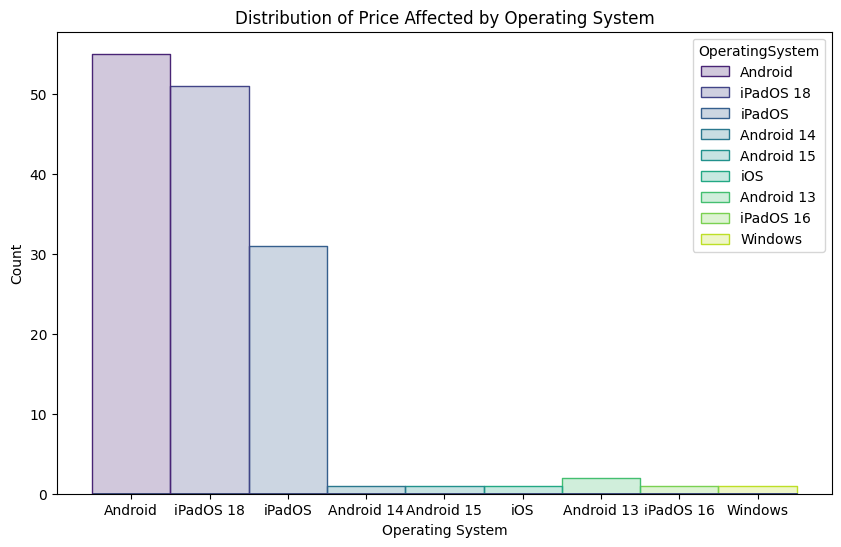

In [ ]:
plt.figure(figsize=(10, 6))
# Using 'hue' allows you to see how OS affects the distribution of Price
sns.histplot(data=df, x='OperatingSystem', hue='OperatingSystem', element="step", palette='viridis')
plt.title('Distribution of Price Affected by Operating System') #změnit název!!
plt.xlabel('Operating System')
plt.show()

/tmp/ipykernel_8870/1313737472.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Brand', y='Price', palette='Set3')


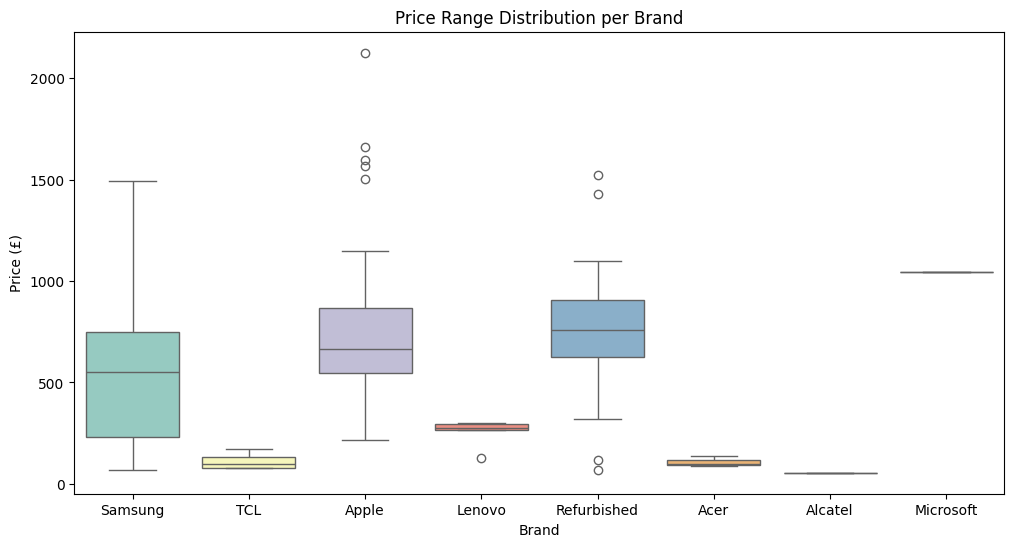

In [ ]:
# Helper: Extract Brand for better visualization - logaritmické měřítko? asi?
df['Brand'] = df['Name'].apply(lambda x: x.split()[0])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Brand', y='Price', palette='Set3')
plt.title('Price Range Distribution per Brand')
plt.ylabel('Price (£)')
plt.show()

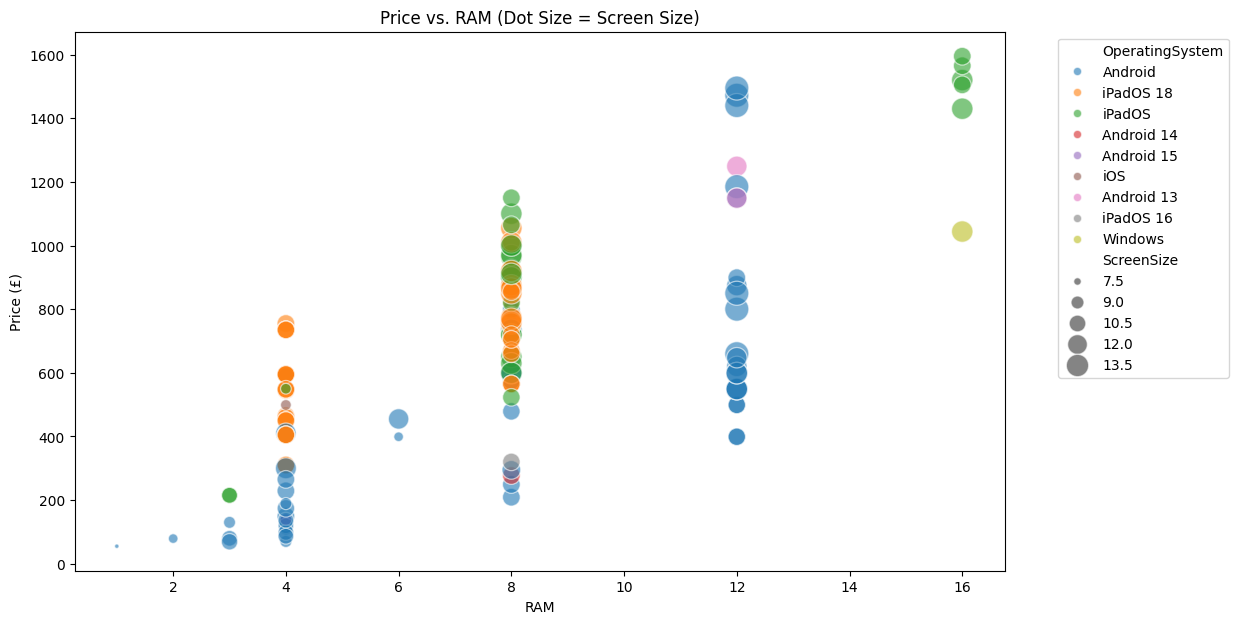

In [80]:
plt.figure(figsize=(12, 7))
# Size of the dots is determined by Screen Size, showing 3-way interaction
sns.scatterplot(data=df, x='RAM', y='Price', size='ScreenSize', hue='OperatingSystem', alpha=0.6, sizes=(10, 300))
plt.title('Price vs. RAM (Dot Size = Screen Size)')
plt.ylabel('Price (£)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

/tmp/ipykernel_8870/3203339900.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='ScreenSize', y='Storage', orient='h', palette='muted')


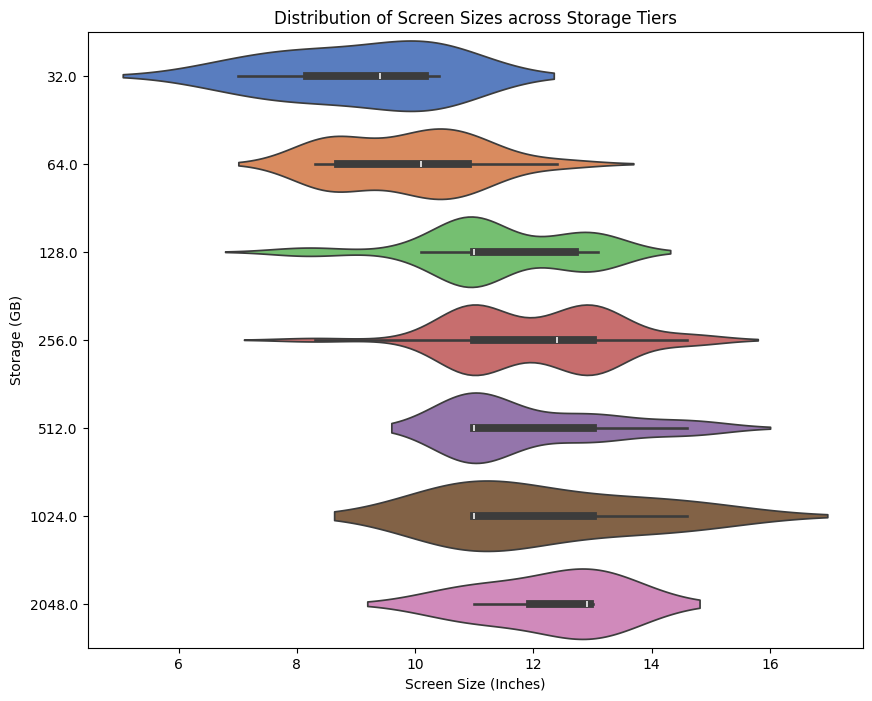

In [82]:
plt.figure(figsize=(10, 8))
# Swapping axes makes it easier to read categories
sns.violinplot(data=df, x='ScreenSize', y='Storage', orient='h', palette='muted')
plt.title('Distribution of Screen Sizes across Storage Tiers')
plt.xlabel('Screen Size (Inches)')
plt.ylabel('Storage (GB)')
plt.show()

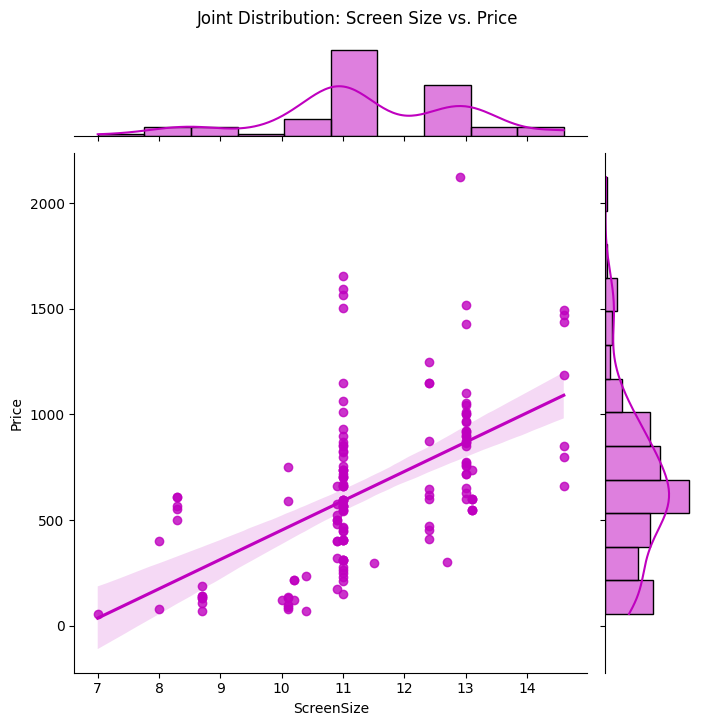

In [83]:
# A JointPlot shows the relationship AND the individual distributions at once
g = sns.jointplot(data=df, x='ScreenSize', y='Price', kind="reg", color="m", height=7)
g.fig.suptitle('Joint Distribution: Screen Size vs. Price', y=1.03)
plt.show()

### Outlier Detection

In [86]:
# IQR Method for Price
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

print(f"Number of price outliers detected: {len(outliers)}")
outliers[['Name', 'Price']]

Number of price outliers detected: 4


,Name,Price
138,"Apple iPad Pro 2021 11"" Silver 2TB Wi-Fi Tablet",1657.97
139,"Apple iPad Pro 2021 12.9"" Space Grey 2TB Wi-Fi...",2124.97
147,"Apple iPad Pro 2024 11"" Space Black 1TB Wi-Fi ...",1564.97
149,"Apple iPad Pro 2024 11"" Silver 1TB Wi-Fi Tablet",1594.97


### Missing Value Analysis

In [ ]:
print("Missing values per column:")
df.isnull().sum()